In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [2]:
data = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [4]:
# extract age of customer
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.to_datetime(data['trans_date_trans_time']).dt.year - data['dob'].dt.year)

In [5]:
# categorise ages
def age_group(age):
    if age < 18:
        return 'Teen'
    elif age < 25:
        return 'Young Adult'
    elif age < 35:
        return 'Adult'
    elif age < 50:
        return 'Middle-aged'
    elif age < 65:
        return 'Senior'
    else:
        return 'Elderly'

data['age_group'] = data['age'].apply(age_group)


In [6]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['day'] = data['trans_date_trans_time'].dt.day
data['month'] = data['trans_date_trans_time'].dt.month
data['year'] = data['trans_date_trans_time'].dt.year
data['hour'] = data['trans_date_trans_time'].dt.hour
data['minute'] = data['trans_date_trans_time'].dt.minute

In [7]:
# extrcat distance 

# Define haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Distance in km

# Apply to dataframe
data['distance_km'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])


In [8]:
data['distance_km'].max()

152.11717310595034

In [9]:
data['distance_km'].min()

0.022254515638533652

In [10]:
# categorise distances for better predictions
def distance_category(dist):
    if dist < 0.5:
        return 'Very Near'         # < 500 meters
    elif dist < 3:
        return 'Near'              # 0.5 – 3 km
    elif dist < 15:
        return 'Moderate'          # 3 – 15 km
    elif dist < 50:
        return 'Far'               # 15 – 50 km
    else:
        return 'Very Far'          # 50 – 152+ km

data['distance_group'] = data['distance_km'].apply(distance_category)


In [11]:
# dropping irrelevant columns
cols_to_drop = [
    'Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip',
    'dob', 'cc_num', 'trans_num', 'unix_time',
    'lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time', 
]

data.drop(columns=cols_to_drop, inplace=True)

In [12]:
data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'is_fraud',
       'age', 'age_group', 'day', 'month', 'year', 'hour', 'minute',
       'distance_km', 'distance_group'],
      dtype='object')

In [13]:
# getting sample data
sample_data = data.sample(frac=0.005, random_state=42)
len(sample_data)

6483

In [14]:
# extracting X and y from sample data
X = sample_data.drop(columns=['is_fraud'])
y = sample_data['is_fraud']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5510, 15)
y_train shape: (5510,)

X_test shape: (973, 15)
y_test shape: (973,)


In [16]:
cols = X_train.columns
print(cols)
print()
cat_cols = X_train.select_dtypes(include="object").columns
print(cat_cols)

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'age_group', 'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

Index(['merchant', 'category', 'gender', 'job', 'age_group', 'distance_group'], dtype='object')


In [17]:
# OrdinalEncoder can tranform all cols at once, instead of one-by-one in LabelEncoding
from sklearn.preprocessing import OrdinalEncoder

# Select categorical columns
cat_cols = sample_data.select_dtypes(include="object").columns.tolist()

# Initialize encoder with unknown handling
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training data and transform both train and test
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [18]:
# that's why i extracted cat_cols above, to scale the numeric cols only
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 577958 to 1113073
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   merchant        5510 non-null   float64
 1   category        5510 non-null   float64
 2   amt             5510 non-null   float64
 3   gender          5510 non-null   float64
 4   city_pop        5510 non-null   int64  
 5   job             5510 non-null   float64
 6   age             5510 non-null   int32  
 7   age_group       5510 non-null   float64
 8   day             5510 non-null   int32  
 9   month           5510 non-null   int32  
 10  year            5510 non-null   int32  
 11  hour            5510 non-null   int32  
 12  minute          5510 non-null   int32  
 13  distance_km     5510 non-null   float64
 14  distance_group  5510 non-null   float64
dtypes: float64(8), int32(6), int64(1)
memory usage: 559.6 KB


In [19]:
# scaling the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Identify numeric columns (not in categorical 'cols') as standard scaler expects 2-d matrix
num_cols = [ col for col in cols if col not in cat_cols ]
print(num_cols)

# make a copy of original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numeric columns
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

['amt', 'city_pop', 'age', 'day', 'month', 'year', 'hour', 'minute', 'distance_km']


In [20]:
X_train_scaled.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'age_group', 'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

In [21]:
print(type(y_test))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Accuracy        : 0.9003083247687564
Precision       : 0.04
Recall          : 0.8
Confusion Matrix:
 [[872  96]
 [  1   4]]


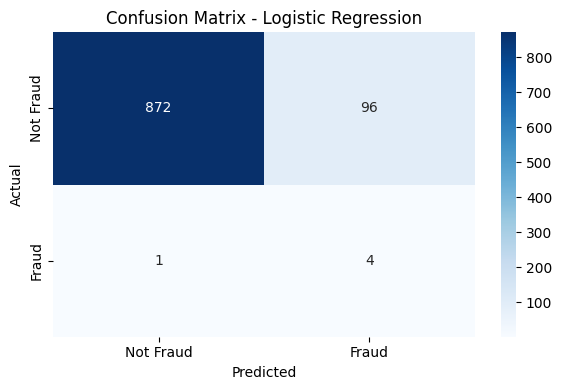

In [22]:
# 1. LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Model
lr = LogisticRegression(solver='lbfgs', penalty="l2", class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

# Metrics
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred, zero_division=0))
print("Recall          :", recall_score(y_test, y_pred))

# Confusion matrix
conf_mt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mt)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


In [23]:
# getting feature relevancy using coeff
feature_names = X_train.columns
coefficients = lr.coef_[0]

# Step 2: Create a DataFrame to sort by importance
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Step 3: View top N important features
print(coef_df.head(10))


           Feature  Coefficient  Importance
2              amt     1.745346    1.745346
3           gender     1.104780    1.104780
14  distance_group    -0.667579    0.667579
9            month     0.580515    0.580515
13     distance_km     0.513579    0.513579
11            hour    -0.337726    0.337726
1         category    -0.156203    0.156203
8              day    -0.137322    0.137322
12          minute    -0.121419    0.121419
7        age_group     0.057518    0.057518


Accuracy        : 0.6855087358684481
Precision       : 0.0
Recall          : 0.0
Confusion Matrix:
 [[667 301]
 [  5   0]]


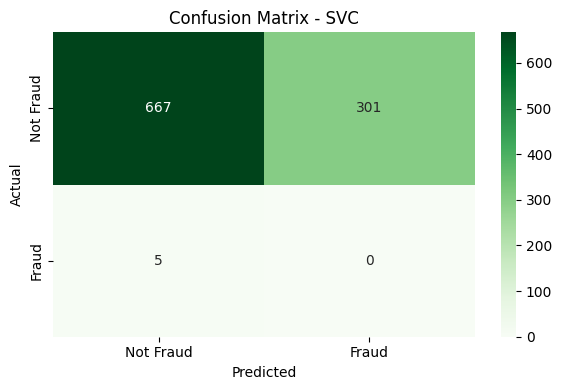

In [24]:
# 2. support vector classifier
from sklearn.svm import SVC

# Initialize SVC model
svc = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Fit the model
svc.fit(X_train_scaled, y_train)

# Predict
y_pred = svc.predict(X_test_scaled)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy        :", acc)

precision = precision_score(y_test, y_pred)
print("Precision       :", precision)

recall = recall_score(y_test, y_pred)
print("Recall          :", recall)

conf_mt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mt)

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Greens', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVC")
plt.tight_layout()
plt.show()


In [25]:
# 3. Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("Precision      :", precision_score(y_test, y_pred))
print("Recall         :", recall_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy       : 0.9948612538540597
Precision      : 0.0
Recall         : 0.0
Confusion Matrix:
[[968   0]
 [  5   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
neg_class = len(y[y==0])
print(neg_class)

pos_class = len(y[y==1])
print(pos_class)

class_weight_ratio = neg_class/pos_class

6446
37


In [27]:
# 4. XgBoost Classifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                    scale_pos_weight=class_weight_ratio,  # optional for imbalance
                    random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("Precision      :", precision_score(y_test, y_pred))
print("Recall         :", recall_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy       : 0.9979445015416238
Precision      : 1.0
Recall         : 0.6
Confusion Matrix:
[[968   0]
 [  2   3]]


In [28]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Create the LightGBM classifier
lgbm = lgb.LGBMClassifier(
    objective='binary',        # since it's a binary classification
    class_weight='balanced',   # handle class imbalance
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1
)

# Fit the model
lgbm.fit(X_train, y_train)

# Predict
y_pred = lgbm.predict(X_test)

# Evaluation
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred))
print("Recall          :", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 32, number of negative: 5478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 5510, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Accuracy  : 0.9958890030832477
Precision : 0.6
Recall    : 0.6
Confusion Matrix:
 [[966   2]
 [  2   3]]


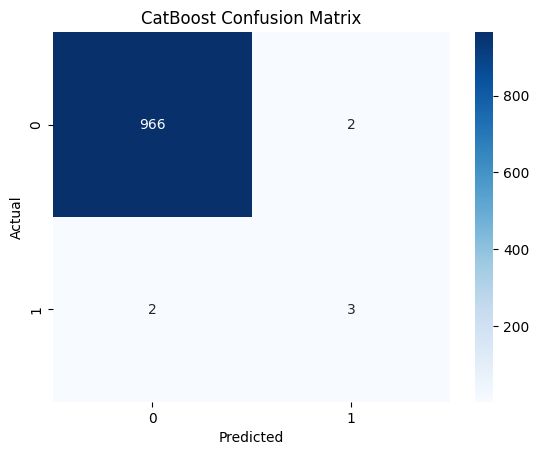

In [29]:
# 5. CatBoost Classifier
from catboost import CatBoostClassifier

# Optional: Set class weights manually or use 'Balanced'
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=0,                      # suppress training output
    allow_writing_files=False,      # avoid saving log files
    auto_class_weights='Balanced', # handle class imbalance automatically
    random_seed=42
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy  : {acc}")
print(f"Precision : {prec}")
print(f"Recall    : {rec}")
print("Confusion Matrix:\n", cm)

# Optional: Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost Confusion Matrix")
plt.show()


In [30]:
# 6. Optimizing XGBoost Classifier Performance
from sklearn.model_selection import GridSearchCV

# Step 1: Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1],
    'scale_pos_weight': [class_weight_ratio],  # already defined earlier based on class imbalance
}

# Step 2: Initialize base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 3: GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='recall',  # prioritize recall in imbalanced cases
                           cv=3, verbose=1, n_jobs=-1)

# Step 4: Fit model
grid_search.fit(X_train, y_train)

# Step 5: Best model
best_model = grid_search.best_estimator_

# Step 6: Predict & Evaluate
y_pred = best_model.predict(X_test)

print("Best Parameters :", grid_search.best_params_)
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred))
print("Recall          :", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
 

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters : {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 174.21621621621622, 'subsample': 0.8}
Accuracy        : 0.9743062692702981
Precision       : 0.14285714285714285
Recall          : 0.8
Confusion Matrix:
 [[944  24]
 [  1   4]]


**Recall really improved from 0.6 to 0.8**

In [31]:
# # 7. Improving LightGBM performance
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# # Base model
# lgbm = lgb.LGBMClassifier(
#     objective='binary',
#     class_weight='balanced',
#     random_state=42,
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=6,
#     min_gain_to_split=0.01,        # Only split if gain is at least 0.01
#     min_data_in_leaf=20,           # Prevents small leaves
#     min_child_samples=20,          # Same as above (alias)
#     n_jobs=-1
# )

# # Parameter grid to search
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [15, 31, 63],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Grid search (prioritize recall in imbalanced class)
# grid_search = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_grid,
#     scoring='recall',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit grid search on training data
# grid_search.fit(X_train, y_train)

# # Best model from grid search
# best_lgbm = grid_search.best_estimator_

# # Predict
# y_pred = best_lgbm.predict(X_test)

# # Evaluate
# print("Best Parameters :", grid_search.best_params_)
# print("Accuracy        :", accuracy_score(y_test, y_pred))
# print("Precision       :", precision_score(y_test, y_pred))
# print("Recall          :", recall_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
